# Setting

In [1]:
import  os
import pandas as pd
import numpy as np
import math
#
from utils.bgem3 import cosine_filter, batch_encode
from utils.call_llm import extract_note, create_summary
from utils.clinical_longformer import langchain_chunk_embed, plain_truncate
from utils.constants import *
#
import torch
from FlagEmbedding import BGEM3FlagModel
from concurrent.futures import ThreadPoolExecutor, as_completed
#
from sklearn.model_selection import train_test_split
from collections import defaultdict, Counter
import pickle
import h5py
#
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

d:\Lab\Research\EMERGE-REPLICATE\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Fetching 30 files: 100%|██████████| 30/30 [00:00<?, ?it/s]
Some weights of LongformerModel were not initialized from the model checkpoint at yikuan8/Clinical-Longformer and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


cuda available: True
model device: cuda:0


# Part 1: Preprocess EHR-Notes Datasets

## I. Preprocess

### Keep only first episode

In [2]:
def clean_patient_ids(INPUT_CSV, OUTPUT_CSV):
    df = pd.read_csv(INPUT_CSV, low_memory=False, encoding="utf-8")
    pid = df["PatientID"].astype(str)
    extracted = pid.str.extract(r"^(?P<base>\d+)(?:_(?P<suf>\d+))?$")

    suf_num = pd.to_numeric(extracted["suf"], errors="coerce")
    keep_mask = suf_num.isna() | (suf_num == 1)
    clean = df.loc[keep_mask].copy()
    clean.loc[:, "PatientID"] = extracted.loc[keep_mask, "base"].astype(str)
    clean.to_csv(OUTPUT_CSV, index=False)

clean_patient_ids(EHR_ZHU, EHR_BACH)
clean_patient_ids(NOTES_ZHU, NOTES_BACH)

C:\Users\ngbac\AppData\Local\Temp\ipykernel_19880\2013730235.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['10000' '10000' '10000' ... '9' '9' '9']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  clean.loc[:, "PatientID"] = extracted.loc[keep_mask, "base"].astype(str)


### Feature Engineering

In [3]:
notes = pd.read_csv(NOTES_BACH, dtype={"PatientID": "string"}, encoding="utf-8", low_memory=False)
ehr   = pd.read_csv(EHR_BACH,   dtype={"PatientID": "string"}, encoding="utf-8", low_memory=False)

# Check for patients with conflicting Outcome or Readmission values
conflict = ehr.groupby("PatientID")[["Outcome", "Readmission"]].nunique()
conflict_patients = conflict[(conflict["Outcome"] > 1) | (conflict["Readmission"] > 1)]

print("Patients with conflicting Outcome or Readmission values:")
print(conflict_patients)

dist = (
    ehr.groupby("PatientID").size()      # rows per patient
       .value_counts()                   # how many patients have that many rows
       .sort_index()                     # sort by row count
)

dist_ge = dist.sort_index(ascending=False).cumsum().sort_index()
print("\nCumulative distribution (>= records):")
for rows, n_patients in dist_ge.items():
    print(f">= {rows} record(s): {n_patients} patients")
    if rows >= 10:
        break

Patients with conflicting Outcome or Readmission values:
Empty DataFrame
Columns: [Outcome, Readmission]
Index: []

Cumulative distribution (>= records):
>= 1 record(s): 33469 patients
>= 2 record(s): 32499 patients
>= 3 record(s): 26152 patients
>= 4 record(s): 20332 patients
>= 5 record(s): 15629 patients
>= 6 record(s): 12695 patients
>= 7 record(s): 10185 patients
>= 8 record(s): 8587 patients
>= 9 record(s): 7282 patients
>= 10 record(s): 6381 patients


In [4]:
# Combine all notes for each patient into a single string, separated by "\n"
notes = (
    notes
    .groupby("PatientID", sort=False)["Text"]
    .apply(lambda s: "\n".join(s.astype(str)))
    .reset_index(name="Text")
)

notes.head()

,PatientID,Text
0,10000,11:30 am chest ( portable ap ) clip # reason :...
1,10003,"admission note d : pt arrived from , sedated o..."
2,10004,respiratory care pt was admitted today from os...
3,10006,full code universal precautions allergy : hepa...
4,10007,12:24 pm chest port . line placement clip # re...


### Remove all patients with less than X records, and keep only X records among those qualified

In [5]:
print(f"Limited to first {RECORDS} EHR rows per patient.")

ehr_counts = ehr.groupby("PatientID").size()
valid_ehr_ids = ehr_counts[ehr_counts >= RECORDS].index
removed_patients = set(ehr["PatientID"].unique()) - set(valid_ehr_ids)
ehr = ehr[ehr["PatientID"].isin(valid_ehr_ids)].reset_index(drop=True)

print(f"Patients removed for having < {RECORDS} EHR rows: {len(removed_patients)}")

ehr = (
    ehr
    .groupby("PatientID", group_keys=False)
    .head(RECORDS)
    .reset_index(drop=True)
)

print(f"EHR rows after truncation: {len(ehr):,}")
print(f"EHR patients: {ehr['PatientID'].nunique():,}")

Limited to first 4 EHR rows per patient.
Patients removed for having < 4 EHR rows: 13137
EHR rows after truncation: 81,328
EHR patients: 20,332


### Keep only patients with both ehr and notes

In [6]:
# normalize IDs a bit (handle stray spaces / empty)
notes["PatientID"] = notes["PatientID"].str.strip()
ehr["PatientID"]   = ehr["PatientID"].str.strip()

# ---- find intersection ----
ids_notes = set(notes["PatientID"].unique())
ids_ehr   = set(ehr["PatientID"].unique())
ids_both  = ids_notes & ids_ehr

# ---- filter to the same set ----
notes_f = notes[notes["PatientID"].isin(ids_both)].copy()
ehr_f   = ehr[ehr["PatientID"].isin(ids_both)].copy()

# ---- sort for readability ----
notes_f = notes_f.sort_values(["PatientID"]).reset_index(drop=True)
ehr_f   = ehr_f.sort_values(["PatientID", "RecordTime"]).reset_index(drop=True)

ehr_f.drop(columns=["RecordTime"], inplace=True)

# ---- save ----
notes_f.to_csv(NOTES_BACH, index=False)
ehr_f.to_csv(EHR_BACH,   index=False)

# ---- report ----
print("=== BEFORE ===")
print(f"Notes: {len(notes):,} rows | {len(ids_notes):,} unique patients")
print(f"EHR  : {len(ehr):,} rows | {len(ids_ehr):,} unique patients")
print("\n=== AFTER (kept only patients present in BOTH) ===")
print(f"Common patients kept: {len(ids_both):,}")
print(f"Notes.filtered.csv: {len(notes_f):,} rows | {notes_f['PatientID'].nunique():,} patients")
print(f"ehr.filtered.csv  : {len(ehr_f):,} rows | {ehr_f['PatientID'].nunique():,} patients")

=== BEFORE ===
Notes: 31,074 rows | 31,074 unique patients
EHR  : 81,328 rows | 20,332 unique patients

=== AFTER (kept only patients present in BOTH) ===
Common patients kept: 19,307
Notes.filtered.csv: 19,307 rows | 19,307 patients
ehr.filtered.csv  : 77,228 rows | 19,307 patients


### Downsampling

In [7]:
# === Downsampling approach: prioritize keeping patients with positive targets ===
print("\n=== DOWNSAMPLING (PRIORITIZING POSITIVE TARGETS) ===")
print("Strategy: Keep all patients with any positive target, remove from stratum 0 (neither positive)")

# Create patient-level dataframe with one row per patient
patient_df = (
    ehr_f.groupby("PatientID")
    .agg(
        Outcome=("Outcome", "first"), 
        Readmission=("Readmission", "first")
    )
    .reset_index()
)

# Create stratification variable (O*2+R gives us 4 strata)
patient_df["stratum"] = (patient_df["Outcome"].astype(int) * 2 + 
                         patient_df["Readmission"].astype(int))

# Current stats
stratum_counts = patient_df["stratum"].value_counts().sort_index()
total_patients = len(patient_df)

print(f"Current distribution: {total_patients:,} patients")
print(f"Stratum 0 (neither): {stratum_counts.get(0, 0):,}")
print(f"Stratum 1 (Readm+ only): {stratum_counts.get(1, 0):,}")
print(f"Stratum 2 (Outcome+ only): {stratum_counts.get(2, 0):,}")
print(f"Stratum 3 (both): {stratum_counts.get(3, 0):,}")

# Keep all positive patients
positive_patients = patient_df[patient_df["stratum"] > 0]["PatientID"].values
num_positive = len(positive_patients)
print(f"\nNumber of patients with any positive target: {num_positive:,}")

# Set random seed for reproducibility
np.random.seed(RANDOM_STATE)

# Try different target sizes
target_sizes = [17000, 16500, 16000, 15500, 15000]
results = []

for target_size in target_sizes:
    # Skip if target size is smaller than the number of positive patients
    if target_size < num_positive:
        print(f"Target size {target_size:,} is smaller than number of positive patients ({num_positive:,}). Skipping.")
        continue
        
    # Calculate how many patients to take from stratum 0
    take_from_stratum0 = target_size - num_positive
    take_from_stratum0 = min(take_from_stratum0, stratum_counts.get(0, 0))
    
    # Sample from stratum 0
    stratum0_patients = patient_df[patient_df["stratum"] == 0]["PatientID"].values
    sampled_from_stratum0 = np.random.choice(stratum0_patients, size=take_from_stratum0, replace=False)
    
    # Combine all selected patients
    sampled_patients = np.concatenate([positive_patients, sampled_from_stratum0])
    
    # Calculate positive ratios
    sampled_df = patient_df[patient_df["PatientID"].isin(sampled_patients)]
    outcome_ratio = sampled_df["Outcome"].mean()
    readm_ratio = sampled_df["Readmission"].mean()
    
    results.append({
        "target_size": target_size,
        "actual_size": len(sampled_df),
        "outcome_ratio": outcome_ratio,
        "readm_ratio": readm_ratio,
        "sampled_patients": sampled_patients
    })
    
    print(f"\n=== Target Size: {target_size:,} ===")
    print(f"Actual Size: {len(sampled_df):,} patients")
    print(f"Outcome+: {outcome_ratio:.1%}")
    print(f"Readmission+: {readm_ratio:.1%}")

best_result = results[-3]  

print("\n=== Selected Sample ===")
print(f"Target Size: {best_result['target_size']:,}")
print(f"Actual Size: {best_result['actual_size']:,} patients")
print(f"Outcome+: {best_result['outcome_ratio']:.1%}")
print(f"Readmission+: {best_result['readm_ratio']:.1%}")

# Filter datasets to keep only sampled patients
sampled_patient_ids = set(best_result['sampled_patients'])
notes_f = notes_f[notes_f["PatientID"].isin(sampled_patient_ids)].copy()
ehr_f = ehr_f[ehr_f["PatientID"].isin(sampled_patient_ids)].copy()

# Save the downsampled data
notes_f.to_csv(NOTES_BACH, index=False)
ehr_f.to_csv(EHR_BACH, index=False)


=== DOWNSAMPLING (PRIORITIZING POSITIVE TARGETS) ===
Strategy: Keep all patients with any positive target, remove from stratum 0 (neither positive)
Current distribution: 19,307 patients
Stratum 0 (neither): 16,377
Stratum 1 (Readm+ only): 732
Stratum 2 (Outcome+ only): 39
Stratum 3 (both): 2,159

Number of patients with any positive target: 2,930

=== Target Size: 17,000 ===
Actual Size: 17,000 patients
Outcome+: 12.9%
Readmission+: 17.0%

=== Target Size: 16,500 ===
Actual Size: 16,500 patients
Outcome+: 13.3%
Readmission+: 17.5%

=== Target Size: 16,000 ===
Actual Size: 16,000 patients
Outcome+: 13.7%
Readmission+: 18.1%

=== Target Size: 15,500 ===
Actual Size: 15,500 patients
Outcome+: 14.2%
Readmission+: 18.7%

=== Target Size: 15,000 ===
Actual Size: 15,000 patients
Outcome+: 14.7%
Readmission+: 19.3%

=== Selected Sample ===
Target Size: 16,000
Actual Size: 16,000 patients
Outcome+: 13.7%
Readmission+: 18.1%


### Splitting Train/Test/Val sets

In [8]:
def cols_between(_df, start_label, end_label=None):
    cols = _df.columns
    start_idx = cols.get_loc(start_label)
    end_idx = len(cols) - 1 if end_label is None else cols.get_loc(end_label)
    if start_idx > end_idx:
        raise ValueError(f"{start_label!r} comes after {end_label!r} in columns")
    return cols[start_idx:end_idx + 1]

def data_split_and_impute():
    df = pd.read_csv(EHR_BACH, encoding='utf-8', low_memory=False)

    pat = (
        df.groupby('PatientID', as_index=False)
            .agg(Outcome=('Outcome','first'),
                Readmission=('Readmission','first'))
    )
    pat['joint'] = pat['Outcome'].astype(int)*2 + pat['Readmission'].astype(int)
    print("Patient counts per joint class (O*2+R):", Counter(pat['joint']))

    # 1) TEST = 20% (stratified on joint)
    pat_trainval, pat_test = train_test_split(
        pat, test_size=0.20, stratify=pat['joint'], random_state=RANDOM_STATE
    )

    # 2) VAL = 12.5% of remaining (i.e., ~10% overall)
    pat_train, pat_val = train_test_split(
        pat_trainval, test_size=0.125, stratify=pat_trainval['joint'], random_state=RANDOM_STATE
    )

    print("Train/Val/Test patients:", len(pat_train), len(pat_val), len(pat_test))

    train_ids = set(pat_train['PatientID'])
    val_ids   = set(pat_val['PatientID'])
    test_ids  = set(pat_test['PatientID'])

    train_df = df[df['PatientID'].isin(train_ids)].copy()
    val_df   = df[df['PatientID'].isin(val_ids)].copy()
    test_df  = df[df['PatientID'].isin(test_ids)].copy()

    for name, d in [('Train', train_df), ('Val', val_df), ('Test', test_df)]:
        print(f"{name}: rows={len(d):,}, patients={d['PatientID'].nunique():,}")

    # ====== DEFINE FEATURE BLOCKS ======
    cat_cols = list(cols_between(
        df,
        "Capillary refill rate->0.0",
        "Glascow coma scale verbal response->3 Inapprop words"
    ))
    num_cols = list(cols_between(df, "Diastolic blood pressure", None))

    # ====== COMPUTE IMPUTATION VALUES ON TRAIN ONLY ======
    # Categorical: all NaNs -> 0 (no stats needed)
    # Numeric: per-column mean from TRAIN
    # Ensure numeric dtype for means; if some numeric cols are object due to bad parsing, coerce safely
    train_num = train_df[num_cols].apply(pd.to_numeric, errors='coerce')
    num_impute = train_num.mean()  # pandas Series indexed by column name

    # ====== APPLY IMPUTATION (USING TRAIN STATS) ======
    def apply_impute(d):
        d = d.copy()
        if cat_cols:
            d.loc[:, cat_cols] = d.loc[:, cat_cols].fillna(0)
        if num_cols:
            d.loc[:, num_cols] = d.loc[:, num_cols].apply(pd.to_numeric, errors='coerce')
            # d.loc[:, num_cols] = d.loc[:, num_cols].fillna(num_impute)
            d.loc[:, num_cols] = d.loc[:, num_cols].fillna(0)  # experimental: simpler
        return d

    train_df_i = apply_impute(train_df)
    val_df_i   = apply_impute(val_df)
    test_df_i  = apply_impute(test_df)

    # ====== QUICK CHECKS AFTER IMPUTATION ======
    def summarize_split(name, df_rows, df_pat):
        o_row = df_rows['Outcome'].mean()
        r_row = df_rows['Readmission'].mean()
        o_pat = df_pat['Outcome'].mean()
        r_pat = df_pat['Readmission'].mean()
        print(
            f"{name} — Outcome: rows={o_row:.3%}, patients={o_pat:.3%} | "
            f"Readmission: rows={r_row:.3%}, patients={r_pat:.3%}"
            f"NaN: {(df_rows.isna().sum().sum())}"
        )

    summarize_split("Train", train_df_i, pat_train)
    summarize_split("Val",   val_df_i,   pat_val)
    summarize_split("Test",  test_df_i,  pat_test)

    train_df_i.to_csv(TRAIN_DRAFT, index=False)
    val_df_i.to_csv(VAL_DRAFT, index=False)
    test_df_i.to_csv(TEST_DRAFT, index=False)

In [9]:
if not os.path.exists(TRAIN_DRAFT) or not os.path.exists(VAL_DRAFT) or not os.path.exists(TEST_DRAFT):
    data_split_and_impute()

Patient counts per joint class (O*2+R): Counter({0: 13070, 3: 2159, 1: 732, 2: 39})
Train/Val/Test patients: 11200 1600 3200
Train: rows=44,800, patients=11,200
Val: rows=6,400, patients=1,600
Test: rows=12,800, patients=3,200
Train — Outcome: rows=13.732%, patients=13.732% | Readmission: rows=18.071%, patients=18.071%NaN: 0
Val — Outcome: rows=13.750%, patients=13.750% | Readmission: rows=18.062%, patients=18.062%NaN: 0
Test — Outcome: rows=13.750%, patients=13.750% | Readmission: rows=18.062%, patients=18.062%NaN: 0


## II. Check

### Check Notes


📊 Character Count Statistics:
min     : 202.00
max     : 52,570.00
mean    : 9,482.84
median  : 7,882.50
std     : 6,564.40
25th    : 4,839.75
75th    : 12,516.25
90th    : 18,456.30
99th    : 31,153.03

📝 Word Count Statistics:
min     : 39.00
max     : 9,521.00
mean    : 1,800.85
median  : 1,511.00
std     : 1,234.74
25th    : 940.00
75th    : 2,373.00
90th    : 3,489.00
99th    : 5,838.07


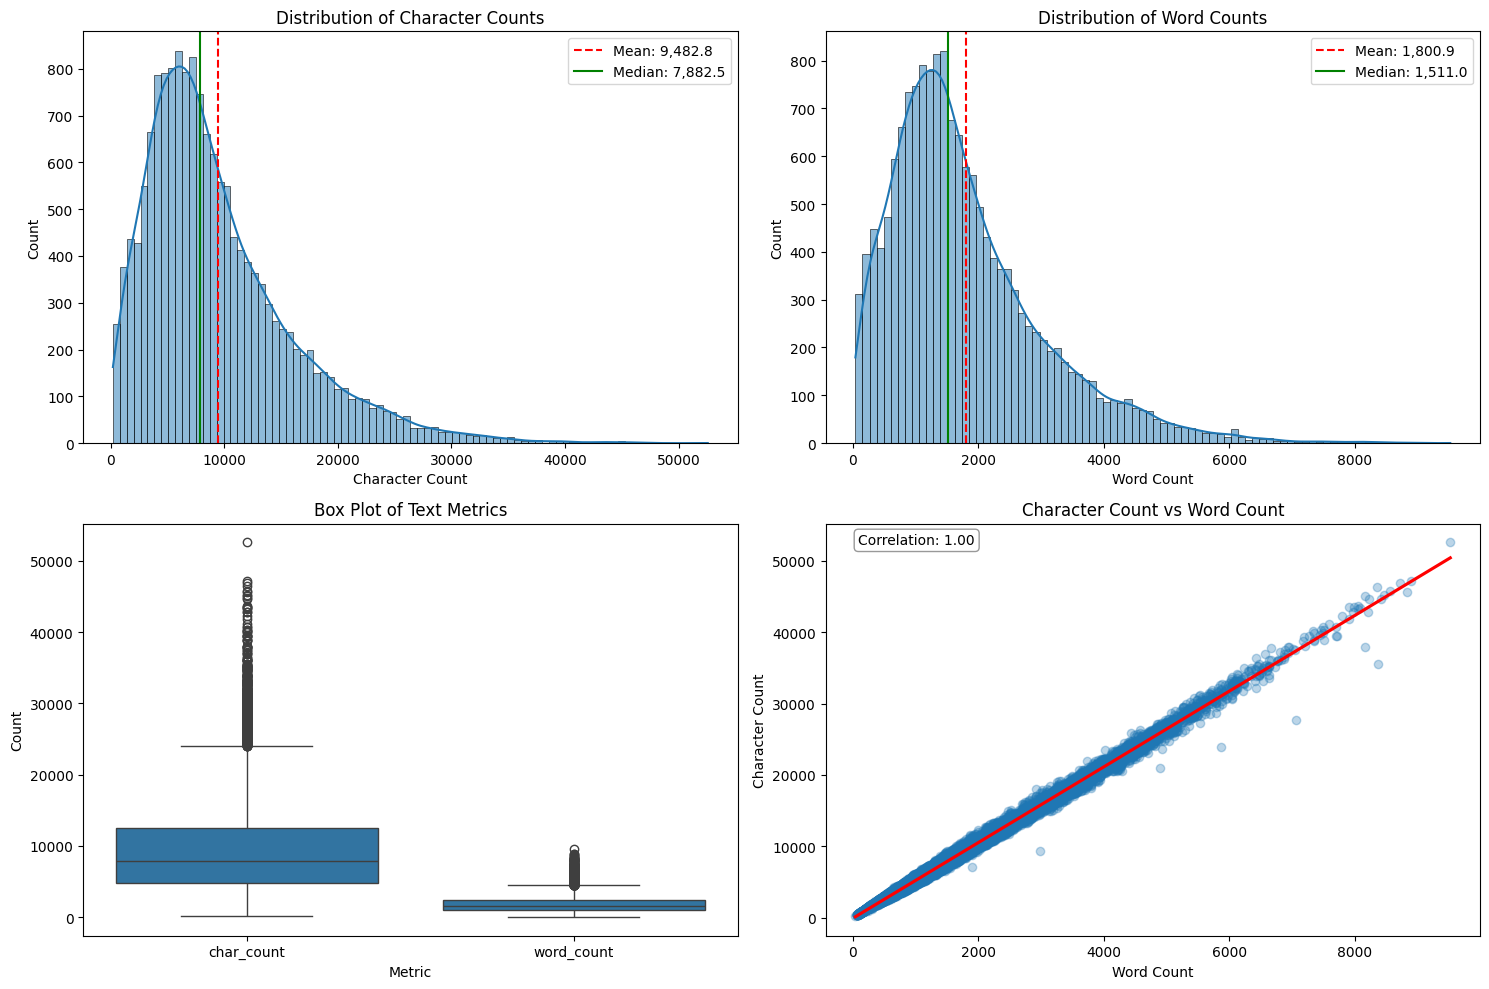

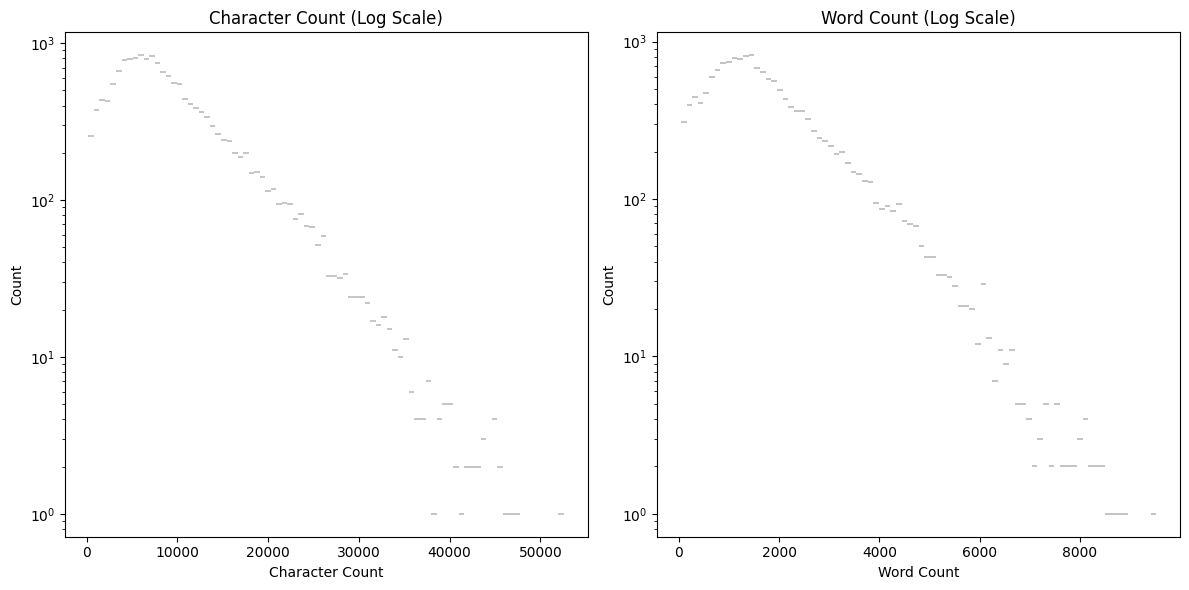


⚠️ Potential Outliers:
Notes with character count > 99th percentile: 160 (1.0%)
Notes with word count > 99th percentile: 160 (1.0%)

📄 Examples from Distribution:
Shortest note: 202 chars, 39 words
Median length note: ~7882 chars, ~1511 words
Longest note: 52570 chars, 9521 words


In [10]:
# Load data
df = pd.read_csv(NOTES_BACH, encoding="utf-8", low_memory=False)

# Calculate character and word counts
df["char_count"] = df["Text"].astype(str).apply(len)
df["word_count"] = df["Text"].astype(str).apply(lambda x: len(x.split()))

# Calculate comprehensive statistics
char_stats = {
    "min": df["char_count"].min(),
    "max": df["char_count"].max(),
    "mean": df["char_count"].mean(),
    "median": df["char_count"].median(),
    "std": df["char_count"].std(),
    "25th": df["char_count"].quantile(0.25),
    "75th": df["char_count"].quantile(0.75),
    "90th": df["char_count"].quantile(0.90),
    "99th": df["char_count"].quantile(0.99)
}

word_stats = {
    "min": df["word_count"].min(),
    "max": df["word_count"].max(),
    "mean": df["word_count"].mean(),
    "median": df["word_count"].median(), 
    "std": df["word_count"].std(),
    "25th": df["word_count"].quantile(0.25),
    "75th": df["word_count"].quantile(0.75),
    "90th": df["word_count"].quantile(0.90),
    "99th": df["word_count"].quantile(0.99)
}

# Print statistics in a nicely formatted way
print("\n📊 Character Count Statistics:")
for k, v in char_stats.items():
    print(f"{k.ljust(8)}: {v:,.2f}")

print("\n📝 Word Count Statistics:")
for k, v in word_stats.items():
    print(f"{k.ljust(8)}: {v:,.2f}")

# Create visualization subplots
plt.figure(figsize=(15, 10))

# 1. Character count histogram
plt.subplot(2, 2, 1)
sns.histplot(data=df, x="char_count", kde=True)
plt.title("Distribution of Character Counts")
plt.xlabel("Character Count")
plt.axvline(char_stats["mean"], color='r', linestyle='--', label=f"Mean: {char_stats['mean']:,.1f}")
plt.axvline(char_stats["median"], color='g', linestyle='-', label=f"Median: {char_stats['median']:,.1f}")
plt.legend()

# 2. Word count histogram
plt.subplot(2, 2, 2)
sns.histplot(data=df, x="word_count", kde=True)
plt.title("Distribution of Word Counts")
plt.xlabel("Word Count")
plt.axvline(word_stats["mean"], color='r', linestyle='--', label=f"Mean: {word_stats['mean']:,.1f}")
plt.axvline(word_stats["median"], color='g', linestyle='-', label=f"Median: {word_stats['median']:,.1f}")
plt.legend()

# 3. Box plot
plt.subplot(2, 2, 3)
# Log scale for better visualization if data is skewed
df_melt = pd.melt(df[["char_count", "word_count"]], var_name="Metric", value_name="Count")
sns.boxplot(x="Metric", y="Count", data=df_melt)
plt.title("Box Plot of Text Metrics")
plt.ylabel("Count")

# 4. Character vs Word count scatter
plt.subplot(2, 2, 4)
sns.regplot(x="word_count", y="char_count", data=df, scatter_kws={"alpha":0.3}, line_kws={"color":"red"})
plt.title("Character Count vs Word Count")
plt.xlabel("Word Count")
plt.ylabel("Character Count")
# Calculate correlation
correlation = df["char_count"].corr(df["word_count"])
plt.annotate(f"Correlation: {correlation:.2f}", xy=(0.05, 0.95), xycoords="axes fraction", 
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

plt.tight_layout()
plt.show()

# Additional plot for outlier analysis with log scale
plt.figure(figsize=(12, 6))

# 5. Histograms with log scale
plt.subplot(1, 2, 1)
sns.histplot(data=df, x="char_count", log_scale=(False, True))
plt.title("Character Count (Log Scale)")
plt.xlabel("Character Count")

plt.subplot(1, 2, 2)
sns.histplot(data=df, x="word_count", log_scale=(False, True))
plt.title("Word Count (Log Scale)")
plt.xlabel("Word Count")

plt.tight_layout()
plt.show()

# Check for extreme outliers
print("\n⚠️ Potential Outliers:")
char_outliers = df[df["char_count"] > char_stats["99th"]].shape[0]
word_outliers = df[df["word_count"] > word_stats["99th"]].shape[0]
print(f"Notes with character count > 99th percentile: {char_outliers} ({char_outliers/len(df):.1%})")
print(f"Notes with word count > 99th percentile: {word_outliers} ({word_outliers/len(df):.1%})")

# Show some examples from different parts of the distribution
print("\n📄 Examples from Distribution:")
print(f"Shortest note: {df['char_count'].min()} chars, {df['word_count'].min()} words")
print(f"Median length note: ~{df['char_count'].median():.0f} chars, ~{df['word_count'].median():.0f} words")
print(f"Longest note: {df['char_count'].max()} chars, {df['word_count'].max()} words")

### Check EHR

In [11]:
df = pd.read_csv(EHR_BACH, encoding="utf-8", low_memory=False)
print("Shape:", df.shape)

print("Outcome positive ratio (each episode):", df["Outcome"].mean())
print("Readmission positive ratio (each episode):", df["Readmission"].mean())

print("===")
pat_any = df.groupby("PatientID")[["Outcome","Readmission"]].max()

print("Outcome positive ratio (each patient):", pat_any["Outcome"].mean())
print("Readmission positive ratio (each patient):", pat_any["Readmission"].mean())

Shape: (64000, 64)
Outcome positive ratio (each episode): 0.137375
Readmission positive ratio (each episode): 0.1806875
===
Outcome positive ratio (each patient): 0.137375
Readmission positive ratio (each patient): 0.1806875


# Part 2: Preprocess PrimeKG and Extract Entities from Datasets

## PrimeKG

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = BGEM3FlagModel("BAAI/bge-m3", use_fp16=True, device=device, trust_remote_code=True)

def create_adj():
    # Create adjacency list
    df = pd.read_csv(PRIMEKG_KG, low_memory=False, encoding="utf-8")
    df = df[["relation", "x_index", "y_index"]]

    adj_list = defaultdict(list)
    for u, v, r in tqdm(zip(df["x_index"].values, df["y_index"].values, df["relation"].values), total=len(df), desc="Creating adjacency list"):
        adj_list[int(u)].append((int(v), str(r)))

    with open(KG_ADJACENCY, "wb") as f:
        pickle.dump(adj_list, f, protocol=5)

def create_disease_features():
    # Create disease feature
    df = pd.read_csv(PRIMEKG_DISEASE, low_memory=False, encoding="utf-8")
    df = df.sort_values("node_index").reset_index(drop=True)

    df["Diseases"] = (
        "[disease name]" + df["mondo_name"].fillna("") + " " +
        "[definition]" + df["mondo_definition"].combine_first(df["orphanet_definition"]).fillna("") + " " +
        "[description]" + df["umls_description"].fillna("")
    )
    df["embed"] = list(batch_encode(df["Diseases"].tolist(), batch_size=64, max_length=8192).cpu().numpy())
    df = df[["node_index", "mondo_name", "Diseases", "embed"]]

    with open(DISEASE_FEATURES, "wb") as f:
        pickle.dump(df, f, protocol=5)

def create_notes_embeddings():
    # Embed notes and save to HDF5
    with h5py.File(NOTES_EMBEDDINGS, "w") as f: # reset file
        pass

    notes_df = pd.read_csv(NOTES_BACH, encoding="utf-8", low_memory=False)
    for idx, row in tqdm(notes_df.iterrows(), total=len(notes_df), desc="Embedding notes and saving to HDF5"):
        patient_id = row["PatientID"]
        text = row["Text"]
        
        with h5py.File(NOTES_EMBEDDINGS, "a") as h5:
            grp = h5.create_group(str(patient_id))
            grp.create_dataset("PatientID", data=np.asarray(patient_id, dtype="int64"))
            # grp.create_dataset("Note", data=langchain_chunk_embed(text), compression="gzip")
            grp.create_dataset("Note", data=plain_truncate(text=text, max_length=256), compression="gzip")

Fetching 30 files: 100%|██████████| 30/30 [00:00<?, ?it/s]


In [13]:
if not os.path.exists(KG_ADJACENCY):
    create_adj()

if not os.path.exists(DISEASE_FEATURES):
    create_disease_features()

if not os.path.exists(NOTES_EMBEDDINGS):
    create_notes_embeddings()

Embedding notes and saving to HDF5: 100%|██████████| 16000/16000 [21:28<00:00, 12.42it/s] 


## Extract Entities

### Create Summaries

In [14]:
with open(DISEASE_FEATURES, "rb") as f:
    kg = pickle.load(f)
mapping = dict(zip(kg["node_index"], kg["mondo_name"]))

with open(KG_ADJACENCY, "rb") as f:
    adj = pickle.load(f)

df = pd.read_csv(NOTES_BACH, encoding="utf-8", low_memory=False)
notes_text = {}
for _, row in df.iterrows():
    pid = row["PatientID"]
    text = row["Text"]
    notes_text[pid] = text

notes_emb = {}
with h5py.File(NOTES_EMBEDDINGS, "r") as h5:
    for patient_id in h5.keys():  # each group is named by patient_id
        grp = h5[patient_id]
        pid = int(grp["PatientID"][()])
        embedding = np.array(grp["Note"])
        notes_emb[pid] = embedding
# print(len(notes_emb.keys()))
# print(notes_emb.keys())
# print(notes_emb[100].shape) # 768

def _to_float32_array(x):
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().float().numpy()
    if isinstance(x, np.ndarray):
        return x.astype("float32", copy=False)
    raise TypeError(f"Expected tensor/ndarray, got {type(x)}")

def store_patient(h5_path, p, ehr, target, notes, summary):
    with h5py.File(h5_path, "a") as h5:
        grp = h5.create_group(str(p))
        grp.create_dataset("PatientID", data=np.asarray(p, dtype="int64"))
        grp.create_dataset("X", data=ehr, compression="gzip")
        grp.create_dataset("Note", data=_to_float32_array(notes), compression="gzip")
        grp.create_dataset("Summary", data=_to_float32_array(summary), compression="gzip")
        grp.create_dataset("Y", data=np.asarray(target, dtype="int8"))

In [15]:
MAX_WORKERS = 1

def create_summary_embeddings(mode = "train"):
    if mode not in ["train", "val", "test"]:
        raise ValueError("mode must be 'train', 'val', or 'test'")
    if mode == "train":
        df = pd.read_csv(TRAIN_DRAFT, encoding="utf-8", low_memory=False)
        h5_path = SUMEMB_TRAIN
    elif mode == "val":
        df = pd.read_csv(VAL_DRAFT, encoding="utf-8", low_memory=False)
        h5_path = SUMEMB_VAL
    else:
        df = pd.read_csv(TEST_DRAFT, encoding="utf-8", low_memory=False)
        h5_path = SUMEMB_TEST

    with h5py.File(h5_path, "w") as f:
        pass
    
    cat_cols = list(cols_between(
        df,
        "Capillary refill rate->0.0",
        "Glascow coma scale verbal response->3 Inapprop words"
    ))
    num_cols = list(cols_between(df, "Diastolic blood pressure", None))

    col_mean = df[num_cols].mean()
    col_std = df[num_cols].std()

    entities = defaultdict(list)
    for idx, row in tqdm(df.iterrows(), total=len(df), desc=f"Processing {mode} data"):
        record = ""
        PatientID = row["PatientID"]

        if row["Sex"] == 1:
            record += "Gender: Male\n"
        else:
            record += "Gender: Female\n"
        record += f"Age: {row['Age']}\n"
        
        for c in cat_cols:
            if row[c] == 1:
                cat = c
                if "Glascow coma scale total" not in cat:
                    for i in range(0, 30, 1):
                        cat = cat.replace(f"->{i}.0", " : ")
                        cat = cat.replace(f"->{i}", " : ")
                cat = cat.replace("->", " : ")
                entities[PatientID].append(cat)
        
        for c in num_cols:
            if math.isnan(row[c]):
                continue
            z_score = (row[c] - col_mean[c]) / col_std[c]
            if z_score > 2:
                entities[PatientID].append(f"{c} too high")
            elif z_score < -2:
                entities[PatientID].append(f"{c} too low")

    # Match entities to knowledge graph
    patients = list(df["PatientID"].unique())

    def get_summary(p):
        entities[p] = list(set(entities[p]))
        summary_entities = ""
        summary_nodes = ""
        summary_edges = ""
        nodes = []
        for e in entities[p]:
            summary_entities += e + ", "
            idx = cosine_filter(None, e, threshold=0.6, top_k=3)
            nodes.extend(idx)
        summary_entities = summary_entities[:-2]

        nodes = list(set(nodes))
        
        for n in nodes:
            summary_nodes += kg.iloc[n]["Diseases"] + ", "
            node_x = kg.iloc[n]["node_index"]
            for connect_to in adj[n]:
                rela = connect_to[1]
                node_y = connect_to[0]
                if node_y not in kg["node_index"].values:
                    continue
                e = "(" + mapping[node_x] + ", " + str(rela) + ", " + mapping[node_y] + ")"
                # print(e)
                summary_edges += e + ", "

        summary_edges = summary_edges[:-2]
        summary_nodes = summary_nodes[:-2]
        summary_notes = extract_note(notes=notes_text[p])

        return create_summary(notes=summary_notes,
                              ehr=summary_entities,
                              nodes=summary_nodes,
                              edges=summary_edges,
                              )

    def worker_summary_only(patient_id):
        return patient_id, get_summary(patient_id)

    summaries = {}
    with ThreadPoolExecutor(max_workers=MAX_WORKERS) as ex:
        futures = {ex.submit(worker_summary_only, pid): pid for pid in patients}
        for fut in tqdm(as_completed(futures), total=len(futures), desc="Summaries embedding...", unit="pt"):
            pid, summary = fut.result()
            summaries[pid] = summary

    text_dtype = h5py.string_dtype(encoding="utf-8")
    with h5py.File(h5_path, "a") as h5:
        for pid, summary in tqdm(summaries.items(), desc="Writing HDF5", unit="pt"):
            gname = str(pid)
            if gname in h5:
                del h5[gname]
            grp = h5.create_group(gname)
            grp.create_dataset("PatientID", data=np.asarray(pid, dtype="int64"))
            grp.create_dataset("SummaryText", data=np.asarray(summary, dtype=object), dtype=text_dtype)
            grp.create_dataset("SummaryEmbedding", data=langchain_chunk_embed(summary), compression="gzip")

In [16]:
# if not os.path.exists(SUMEMB_TRAIN):
#     create_summary_embeddings("train")

# if not os.path.exists(SUMEMB_VAL):
#     create_summary_embeddings("val")

# if not os.path.exists(SUMEMB_TEST):
#     create_summary_embeddings("test")

In [17]:
summaries = {}
def load_summary_embeddings(h5_path):
    with h5py.File(h5_path, "r") as h5:
        for gname, grp in h5.items():
            summaries[int(gname)] = {
                "PatientID": int(grp["PatientID"][()]),
                "SummaryText": grp["SummaryText"].asstr()[()],
                "SummaryEmbedding": grp["SummaryEmbedding"][()]
            }

def create_dataset(mode = "train"):
    if mode not in ["train", "val", "test"]:
        raise ValueError("mode must be 'train', 'val', or 'test'")
    if mode == "train":
        df = pd.read_csv(TRAIN_DRAFT, encoding="utf-8", low_memory=False)
        h5_path = TRAIN
        # load_summary_embeddings(SUMEMB_TRAIN)
    elif mode == "val":
        df = pd.read_csv(VAL_DRAFT, encoding="utf-8", low_memory=False)
        h5_path = VAL
        # load_summary_embeddings(SUMEMB_VAL)
    else:
        df = pd.read_csv(TEST_DRAFT, encoding="utf-8", low_memory=False)
        h5_path = TEST
        # load_summary_embeddings(SUMEMB_TEST)

    with h5py.File(h5_path, "w") as f:
        pass

    patients = list(df["PatientID"].unique())
    feature_cols = [c for c in df.columns if c not in ["PatientID","Outcome","Readmission"]]
    target_map = df.groupby("PatientID")[["Outcome","Readmission"]].first()

    for p in tqdm(patients, total=len(patients), desc=f"Storing {mode} data to HDF5"):
        data_ehr = df.loc[df["PatientID"] == p, feature_cols].to_numpy()
        data_notes = notes_emb[p]
        data_summary = data_notes # fallback to notes embedding if summary missing
        # data_summary = summaries[p]["SummaryEmbedding"]
        outcome, readm = target_map.loc[p].astype(int)
        data_target = (int(outcome), int(readm))
        store_patient(h5_path, p, data_ehr, data_target, data_notes, data_summary)

In [18]:
if not os.path.exists(TRAIN) or not os.path.exists(VAL) or not os.path.exists(TEST):
    create_dataset(mode="train")
    create_dataset(mode="val")
    create_dataset(mode="test")

Storing test data to HDF5: 100%|██████████| 3200/3200 [02:20<00:00, 22.82it/s]
